In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.max_columns", None)

In [14]:
# Load data
df = pd.read_csv("bank_transactions_data_2.csv")

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(df.head())
print()
print(df.info())

print("\nBasic numeric summary:")
print(df[["TransactionAmount", "CustomerAge",
          "TransactionDuration", "LoginAttempts",
          "AccountBalance"]].describe())


DATASET OVERVIEW
  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor     

In [15]:
print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

print("\nShape after dropping duplicates:", df.shape)


Missing values per column:
TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

Duplicate rows: 0

Shape after dropping duplicates: (2512, 16)


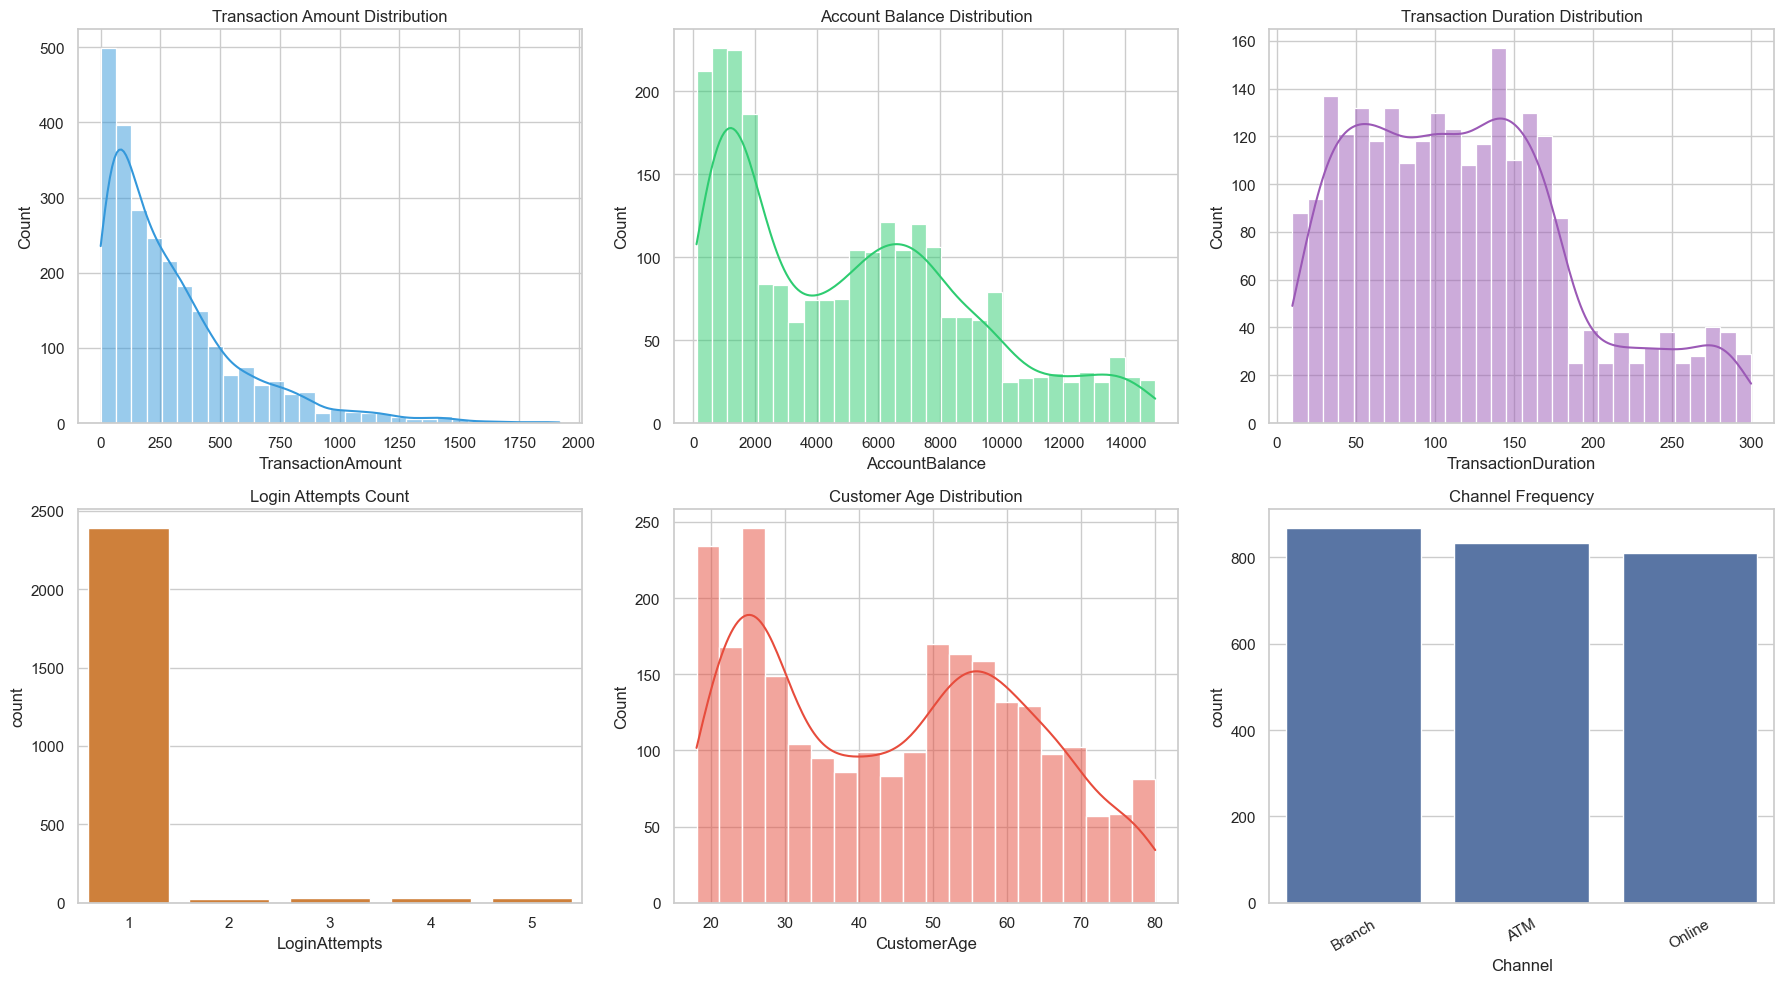

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

sns.histplot(df["TransactionAmount"], bins=30, ax=axes[0], kde=True, color="#3498db")
axes[0].set_title("Transaction Amount Distribution")

sns.histplot(df["AccountBalance"], bins=30, ax=axes[1], kde=True, color="#2ecc71")
axes[1].set_title("Account Balance Distribution")

sns.histplot(df["TransactionDuration"], bins=30, ax=axes[2], kde=True, color="#9b59b6")
axes[2].set_title("Transaction Duration Distribution")

sns.countplot(x="LoginAttempts", data=df, ax=axes[3], color="#e67e22")
axes[3].set_title("Login Attempts Count")

sns.histplot(df["CustomerAge"], bins=20, ax=axes[4], kde=True, color="#e74c3c")
axes[4].set_title("Customer Age Distribution")

sns.countplot(x="Channel", data=df, ax=axes[5], order=df["Channel"].value_counts().index)
axes[5].set_title("Channel Frequency")
axes[5].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()



GENERATING VISUALIZATIONS


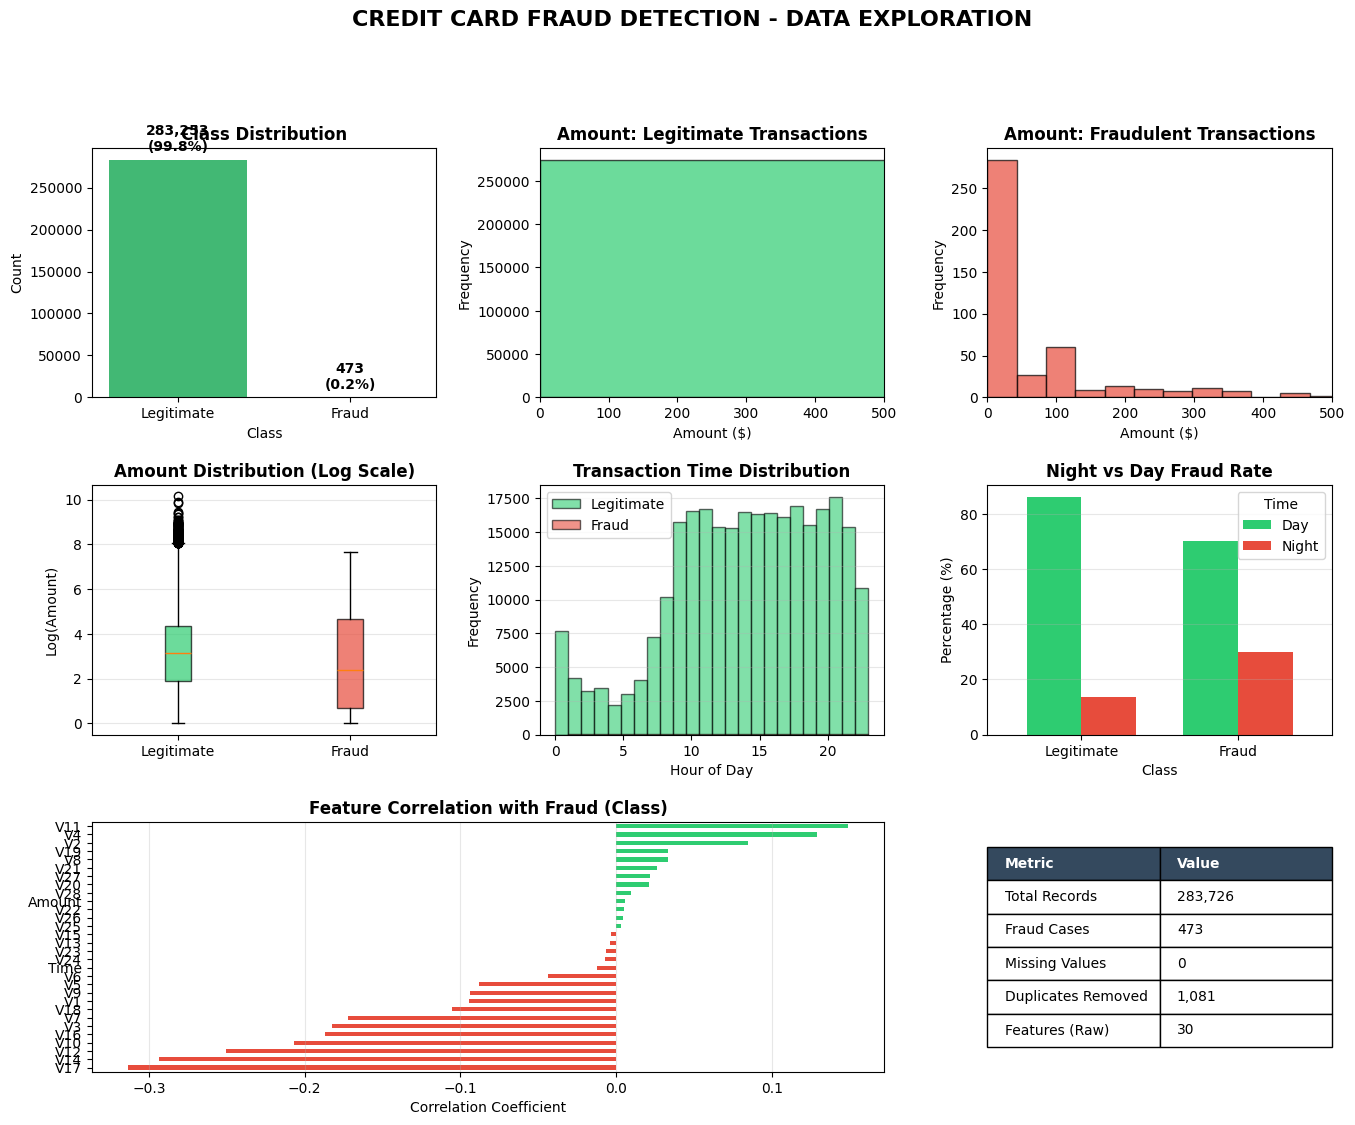

✓ Saved: 01_data_exploration_dashboard.png


In [4]:
print(f"\n{'='*70}")
print("GENERATING VISUALIZATIONS")
print(f"{'='*70}")

# Create a comprehensive dashboard
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Class Distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(x='Class', data=df, ax=ax1, palette=['#2ecc71', '#e74c3c'])
ax1.set_title('Class Distribution', fontweight='bold', fontsize=12)
ax1.set_xticklabels(['Legitimate', 'Fraud'])
ax1.set_ylabel('Count')
for i, v in enumerate(class_dist):
    ax1.text(i, v + 10000, f'{v:,}\n({100*v/len(df):.1f}%)', 
             ha='center', fontweight='bold')

# 2. Amount Distribution (Legitimate)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df[df['Class']==0]['Amount'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
ax2.set_title('Amount: Legitimate Transactions', fontweight='bold', fontsize=12)
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 500)  # Zoom for clarity

# 3. Amount Distribution (Fraud)
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(df[df['Class']==1]['Amount'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax3.set_title('Amount: Fraudulent Transactions', fontweight='bold', fontsize=12)
ax3.set_xlabel('Amount ($)')
ax3.set_ylabel('Frequency')
ax3.set_xlim(0, 500)

# 4. Amount Boxplot (Log scale for better visibility)
ax4 = fig.add_subplot(gs[1, 0])
df_plot = df.copy()
df_plot['Log_Amount'] = np.log1p(df_plot['Amount'])
bp = ax4.boxplot([df_plot[df_plot['Class']==0]['Log_Amount'],
                    df_plot[df_plot['Class']==1]['Log_Amount']],
                   labels=['Legitimate', 'Fraud'],
                   patch_artist=True)
for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_title('Amount Distribution (Log Scale)', fontweight='bold', fontsize=12)
ax4.set_ylabel('Log(Amount)')
ax4.grid(axis='y', alpha=0.3)

# 5. Time Distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(df[df['Class']==0]['Hour'], bins=24, color='#2ecc71', alpha=0.6, label='Legitimate', edgecolor='black')
ax5.hist(df[df['Class']==1]['Hour'], bins=24, color='#e74c3c', alpha=0.6, label='Fraud', edgecolor='black')
ax5.set_title('Transaction Time Distribution', fontweight='bold', fontsize=12)
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Frequency')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Is_Night Feature
ax6 = fig.add_subplot(gs[1, 2])
night_dist = pd.crosstab(df['Is_Night'], df['Class'], normalize='columns') * 100
night_dist.T.plot(kind='bar', ax=ax6, color=['#2ecc71', '#e74c3c'], width=0.7)
ax6.set_title('Night vs Day Fraud Rate', fontweight='bold', fontsize=12)
ax6.set_ylabel('Percentage (%)')
ax6.set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
ax6.legend(['Day', 'Night'], title='Time')
ax6.grid(axis='y', alpha=0.3)

# 7. Top Features Correlation
ax7 = fig.add_subplot(gs[2, :2])
correlations = df[[f'V{i}' for i in range(1, 29)] + ['Amount', 'Time', 'Class']].corr()['Class'].drop('Class').sort_values()
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in correlations.values]
correlations.plot(kind='barh', ax=ax7, color=colors)
ax7.set_title('Feature Correlation with Fraud (Class)', fontweight='bold', fontsize=12)
ax7.set_xlabel('Correlation Coefficient')
ax7.grid(axis='x', alpha=0.3)

# 8. Summary Statistics Table
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('tight')
ax8.axis('off')
summary_data = [
    ['Metric', 'Value'],
    ['Total Records', f'{len(df):,}'],
    ['Fraud Cases', f'{class_dist[1]:,}'],
    ['Missing Values', '0'],
    ['Duplicates Removed', '1,081'],
    ['Features (Raw)', '30'],
]
table = ax8.table(cellText=summary_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(len(summary_data)):
    if i == 0:
        table[(i, 0)].set_facecolor('#34495e')
        table[(i, 1)].set_facecolor('#34495e')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')

plt.suptitle('CREDIT CARD FRAUD DETECTION - DATA EXPLORATION', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('01_data_exploration_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 01_data_exploration_dashboard.png")

In [17]:
# ID / date‑like columns we won't use as features
id_cols = ["TransactionID", "AccountID", "IP Address", "PreviousTransactionDate"]
date_cols = ["TransactionDate"]   # optional, can engineer later

feature_cols = [c for c in df.columns if c not in id_cols]

X = df[feature_cols].copy()

numeric_features = ["TransactionAmount", "CustomerAge",
                    "TransactionDuration", "LoginAttempts",
                    "AccountBalance"]

categorical_features = [c for c in X.columns if c not in numeric_features]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numeric features: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
Categorical features: ['TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'MerchantID', 'Channel', 'CustomerOccupation']


In [18]:
print("\n" + "="*70)
print("ANOMALY DETECTION WITH ISOLATION FOREST")
print("="*70)

# Contamination is the expected proportion of anomalies (tunable: 0.01–0.05)
iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)

iso_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", iso_forest)
])

iso_pipeline.fit(X)

# Get anomaly labels and scores
X_trans = iso_pipeline["preprocess"].transform(X)
labels_iso = iso_pipeline["model"].predict(X_trans)         # 1 = normal, -1 = anomaly
scores_iso = -iso_pipeline["model"].score_samples(X_trans)  # higher = more anomalous

df["IF_AnomalyLabel"] = (labels_iso == -1).astype(int)
df["IF_AnomalyScore"] = scores_iso

print("\nIsolation Forest flagged {} anomalies out of {} transactions ({:.2f}%)"
      .format(df["IF_AnomalyLabel"].sum(), len(df),
              100*df["IF_AnomalyLabel"].mean()))



ANOMALY DETECTION WITH ISOLATION FOREST

Isolation Forest flagged 51 anomalies out of 2512 transactions (2.03%)


In [19]:
print("\n" + "="*70)
print("ANOMALY DETECTION WITH LOCAL OUTLIER FACTOR (LOF)")
print("="*70)

# LOF works directly on the transformed features
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.02,
    novelty=False  # standard unsupervised LOF
)

# Fit + predict in one go
lof_labels = lof.fit_predict(X_trans)     # 1 = normal, -1 = outlier
lof_scores = -lof.negative_outlier_factor_

df["LOF_AnomalyLabel"] = (lof_labels == -1).astype(int)
df["LOF_AnomalyScore"] = lof_scores

print("\nLOF flagged {} anomalies out of {} transactions ({:.2f}%)"
      .format(df["LOF_AnomalyLabel"].sum(), len(df),
              100*df["LOF_AnomalyLabel"].mean()))


ANOMALY DETECTION WITH LOCAL OUTLIER FACTOR (LOF)

LOF flagged 51 anomalies out of 2512 transactions (2.03%)


In [20]:
print("\n" + "="*70)
print("COMPARING ISOLATION FOREST AND LOF")
print("="*70)

# Agreement between both detectors
both_anomaly = (df["IF_AnomalyLabel"] == 1) & (df["LOF_AnomalyLabel"] == 1)
print("\nTransactions flagged by BOTH models:", both_anomaly.sum())

# Top‑N most anomalous according to Isolation Forest
N = 30
top_if = df.sort_values("IF_AnomalyScore", ascending=False).head(N)

cols_to_show = [
    "TransactionID", "TransactionAmount", "CustomerAge",
    "TransactionDuration", "LoginAttempts", "AccountBalance",
    "TransactionType", "Location", "DeviceID", "Channel",
    "IF_AnomalyScore", "LOF_AnomalyScore"
]

print("\nTop {} most anomalous transactions (Isolation Forest):".format(N))
display(top_if[cols_to_show])



COMPARING ISOLATION FOREST AND LOF

Transactions flagged by BOTH models: 2

Top 30 most anomalous transactions (Isolation Forest):


,TransactionID,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,TransactionType,Location,DeviceID,Channel,IF_AnomalyScore,LOF_AnomalyScore
1142,TX001143,568.88,19,105,1,1307.86,Debit,Nashville,D000321,Branch,0.314027,1.007360
1703,TX001704,1294.81,45,279,1,9927.75,Credit,Washington,D000489,Branch,0.312497,1.107985
1972,TX001973,1087.90,78,103,1,2513.51,Debit,Boston,D000549,ATM,0.312401,1.048192
2140,TX002141,519.62,71,40,1,4159.33,Credit,Washington,D000046,Online,0.312368,1.008631
1226,TX001227,775.60,79,158,1,3898.64,Credit,Mesa,D000627,Branch,0.312352,1.034486
2217,TX002218,275.98,72,67,1,6151.05,Credit,Washington,D000652,Online,0.312181,0.998589
1052,TX001053,168.00,32,11,1,3498.58,Credit,Tucson,D000669,Branch,0.312032,1.013928
1897,TX001898,702.87,19,184,1,1237.50,Debit,Washington,D000352,ATM,0.311706,1.012090
1362,TX001363,54.85,58,40,1,2727.45,Credit,San Francisco,D000287,Branch,0.311683,1.002207
2132,TX002133,341.88,43,89,1,4159.52,Debit,Austin,D000321,ATM,0.311523,0.994805


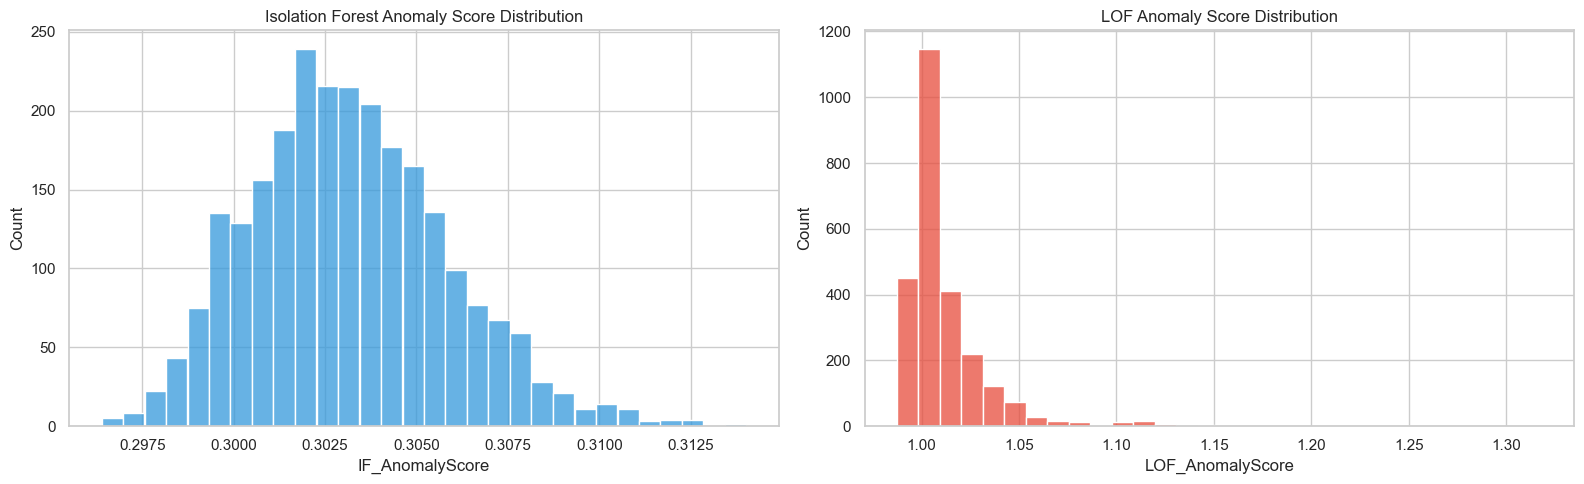

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df["IF_AnomalyScore"], bins=30, ax=axes[0], color="#3498db")
axes[0].set_title("Isolation Forest Anomaly Score Distribution")

sns.histplot(df["LOF_AnomalyScore"], bins=30, ax=axes[1], color="#e74c3c")
axes[1].set_title("LOF Anomaly Score Distribution")

plt.tight_layout()
plt.show()


In [22]:
def compare_group_stats(col):
    g = df.groupby("IF_AnomalyLabel")[col].describe()[["mean", "std", "min", "25%", "50%", "75%", "max"]]
    g.index = ["Normal (0)", "Anomaly (1)"]
    print("\n" + "="*40)
    print(f"Distribution of {col} for normal vs anomalies")
    print("="*40)
    print(g)

for c in ["TransactionAmount", "AccountBalance",
          "TransactionDuration", "LoginAttempts"]:
    compare_group_stats(c)



Distribution of TransactionAmount for normal vs anomalies
                   mean         std   min     25%     50%      75%      max
Normal (0)   295.095043  289.925847  0.26   81.27  208.07  410.400  1919.11
Anomaly (1)  418.170000  360.056472  7.76  121.52  318.92  665.875  1294.81

Distribution of AccountBalance for normal vs anomalies
                    mean          std     min       25%      50%      75%  \
Normal (0)   5126.041142  3898.397994  101.25  1508.720  4746.71  7707.96   
Anomaly (1)  4547.878431  4020.455292  151.28  1230.135  3791.99  6310.46   

                  max  
Normal (0)   14977.99  
Anomaly (1)  14935.50  

Distribution of TransactionDuration for normal vs anomalies
                   mean        std   min   25%    50%    75%    max
Normal (0)   119.696059  69.692241  10.0  63.0  113.0  161.0  300.0
Anomaly (1)  117.098039  82.774937  11.0  55.5   84.0  163.5  290.0

Distribution of LoginAttempts for normal vs anomalies
                 mean       std  